Is early stopping better than tuning the number of trees in LightGBM? Benchmarked on the [bank-account-fraud dataset](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022) (published at NeurIPS'22).

**Executive Summary**
- There does not seem to be a significant difference in performance between tuning the number of boosting iterations and using early stopping with a high maximum number of trees.
- The early stopping strategy more than halves average training time.

In [1]:
import warnings
import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('whitegrid')

In [3]:
SEED = 42
N_TRIALS = 100

# Data Loading

In [4]:
df = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


In [5]:
TIMESTAMP_COL = 'month'
LABEL_COL = 'fraud_bool'
CATEGORICAL_COLS = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

# LightGBM and XGBoost use this to treat categoricals differently:
df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].astype('category')

train = df[df[TIMESTAMP_COL] <= 5].drop(columns=TIMESTAMP_COL)
val = df[df[TIMESTAMP_COL] == 6].drop(columns=TIMESTAMP_COL)
test = df[df[TIMESTAMP_COL] == 7].drop(columns=TIMESTAMP_COL)

X_train, y_train = train.drop(columns=[LABEL_COL]), train[LABEL_COL]
X_val, y_val = val.drop(columns=[LABEL_COL]), val[LABEL_COL]
X_test, y_test = test.drop(columns=[LABEL_COL]), test[LABEL_COL]

In [6]:
dataset_params = dict(
    categorical_feature=CATEGORICAL_COLS,
    free_raw_data=False,
)
dtrain = lgb.Dataset(X_train, label=y_train, **dataset_params)
dval = lgb.Dataset(X_val, label=y_val, **dataset_params).construct()
dtest = lgb.Dataset(X_test, label=y_test, **dataset_params).construct()

# Hyperparameter Tuning

In [7]:
# aux functions for binary classification evaluation
def calc_threshold_at_fpr(y_true: np.ndarray, y_score: np.ndarray, fpr: float):
    temp_df = pd.DataFrame(
        {'y_true': y_true,
         'y_score': y_score,
         })
    temp_df = temp_df.sort_values(by='y_score', ascending=False, ignore_index=True)
    temp_df['pseudo_fpr'] = (temp_df['y_true']
                             .apply(lambda x: 1 if x == 0 else 0)
                             .cumsum()
                             .divide(sum(y_true == 0)))

    critical_threshold = float((
        temp_df
        .loc[temp_df['pseudo_fpr'] < fpr, 'y_score']
        .iloc[-1]))

    return critical_threshold

def predict_at_fpr(y_true: np.ndarray, y_score: np.ndarray, fpr: float):
    threshold_at_fpr = calc_threshold_at_fpr(
        y_true=y_true, y_score=y_score, fpr=fpr)

    return (y_score > threshold_at_fpr).astype(int)

In [8]:
NON_TUNED_PARAMS = dict(
    objective='binary',
    verbosity='-1',
    enable_bundle=True,
    feature_pre_filter=False,  # to enable min_child_samples exploration
)

In [9]:
def _objective(trial, dtrain, dval, dtest, categorical_cols, early_stopping, optimization_logs):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 256, log=True),
        'bagging_freq': trial.suggest_categorical('bagging_freq', [0, 1]),
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.1, 1),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
    }

    model = lgb.train(
        {**NON_TUNED_PARAMS, **params},
        dtrain,
        categorical_feature=categorical_cols,
        num_boost_round=(
            4000 if early_stopping
            else trial.suggest_int('num_boost_rounds', 10, 4000)
        ),
        valid_sets=dval if early_stopping else None,
        callbacks=(
            [lgb.early_stopping(stopping_rounds=100, verbose=False)] if early_stopping
            else None
        ),
    )

    y_val = dval.get_label()
    y_val_score = model.predict(dval.get_data())
    y_test = dtest.get_label()  # test eval for experimental purposes
    y_test_score = model.predict(dtest.get_data())

    artifacts = {
        # 'y_score': y_score,
        'num_boosting_rounds': model.num_trees(),
        'log_loss': metrics.log_loss(y_true=y_val, y_pred=y_val_score),
        'recall_at_fpr': metrics.recall_score(y_true=y_val, y_pred=predict_at_fpr(y_val, y_val_score, fpr=0.05)),
        'test_log_loss': metrics.log_loss(y_true=y_test, y_pred=y_test_score),
        'test_recall_at_fpr': metrics.recall_score(y_true=y_test, y_pred=predict_at_fpr(y_test, y_test_score, fpr=0.05)),
    }
    optimization_logs.append(artifacts)

    return artifacts['log_loss']

In [10]:
NO_ES_OPTIMIZATION_LOGS = []  # keep records
no_es_study = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=SEED),
    directions=['minimize'],  # ignored (random sampling)
)
no_es_study.optimize(
    lambda trial: _objective(
        trial=trial,
        dtrain=dtrain, dval=dval, dtest=dtest, categorical_cols=CATEGORICAL_COLS,
        early_stopping=False,
        optimization_logs=NO_ES_OPTIMIZATION_LOGS),
    n_trials=N_TRIALS,
)

In [11]:
ES_OPTIMIZATION_LOGS = []  # keep records
es_study = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=SEED),
    directions=['minimize'],  # ignored (random sampling)
)
es_study.optimize(
    lambda trial: _objective(
        trial=trial,
        dtrain=dtrain, dval=dval, dtest=dtest, categorical_cols=CATEGORICAL_COLS,
        early_stopping=True,
        optimization_logs=ES_OPTIMIZATION_LOGS),
    n_trials=N_TRIALS,
)

[LightGBM] [Fatal] Cannot change feature_pre_filter after constructed Dataset handle.


# Analysis

In [12]:
no_es_results = pd.concat([no_es_study.trials_dataframe(), pd.DataFrame(NO_ES_OPTIMIZATION_LOGS)], axis=1)
no_es_results[f'best_log_loss'] = no_es_results['log_loss'].expanding().min()
no_es_results[f'best_recall_at_fpr'] = no_es_results['recall_at_fpr'].expanding().max()
no_es_results[f'test_best_log_loss'] = no_es_results['test_log_loss'].expanding().min()
no_es_results[f'test_best_recall_at_fpr'] = no_es_results['test_recall_at_fpr'].expanding().max()
no_es_results

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_boosting_type,params_learning_rate,params_max_depth,params_min_child_samples,...,state,num_boosting_rounds,log_loss,recall_at_fpr,test_log_loss,test_recall_at_fpr,best_log_loss,best_recall_at_fpr,test_best_log_loss,test_best_recall_at_fpr
0,0,0.056384,2023-03-05 12:30:23.335327,2023-03-05 12:33:47.511245,0 days 00:03:24.175918,1,goss,0.175241,3,3,...,COMPLETE,3332,0.056384,0.489655,0.066108,0.471989,0.056384,0.489655,0.066108,0.471989
1,1,0.054753,2023-03-05 12:33:47.511746,2023-03-05 12:36:44.732082,0 days 00:02:57.220336,1,gbdt,0.020493,6,14,...,COMPLETE,3143,0.054753,0.526207,0.060866,0.545518,0.054753,0.526207,0.060866,0.545518
2,2,0.052659,2023-03-05 12:36:44.732584,2023-03-05 12:38:57.136329,0 days 00:02:12.403745,1,goss,0.101507,7,4,...,COMPLETE,2740,0.052659,0.532414,0.055629,0.574930,0.052659,0.532414,0.055629,0.574930
3,3,0.052640,2023-03-05 12:38:57.136782,2023-03-05 12:40:46.634173,0 days 00:01:49.497391,0,gbdt,0.069389,10,6,...,COMPLETE,3103,0.052640,0.531034,0.055568,0.578431,0.052640,0.532414,0.055568,0.578431
4,4,0.053134,2023-03-05 12:40:46.634669,2023-03-05 12:41:45.528065,0 days 00:00:58.893396,1,gbdt,0.103708,2,4,...,COMPLETE,1131,0.053134,0.524828,0.055689,0.573529,0.052640,0.532414,0.055568,0.578431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.053511,2023-03-05 15:49:58.985511,2023-03-05 15:50:08.905782,0 days 00:00:09.920271,0,goss,0.063675,3,131,...,COMPLETE,139,0.053511,0.520000,0.056381,0.570028,0.052539,0.536552,0.055036,0.588235
96,96,0.055094,2023-03-05 15:50:08.906363,2023-03-05 15:51:02.719376,0 days 00:00:53.813013,0,gbdt,0.225576,3,3,...,COMPLETE,1083,0.055094,0.510345,0.064260,0.495098,0.052539,0.536552,0.055036,0.588235
97,97,0.059910,2023-03-05 15:51:02.719860,2023-03-05 15:51:09.652615,0 days 00:00:06.932755,1,gbdt,0.059348,2,11,...,COMPLETE,168,0.059910,0.484138,0.065084,0.520308,0.052539,0.536552,0.055036,0.588235
98,98,0.075941,2023-03-05 15:51:09.653085,2023-03-05 15:51:26.540606,0 days 00:00:16.887521,1,gbdt,0.025777,3,20,...,COMPLETE,360,0.075941,0.526207,0.073662,0.572129,0.052539,0.536552,0.055036,0.588235


In [13]:
es_results = pd.concat([es_study.trials_dataframe(), pd.DataFrame(ES_OPTIMIZATION_LOGS)], axis=1)
es_results[f'best_log_loss'] = es_results['log_loss'].expanding().min()
es_results[f'best_recall_at_fpr'] = es_results['recall_at_fpr'].expanding().max()
es_results[f'test_best_log_loss'] = es_results['test_log_loss'].expanding().min()
es_results[f'test_best_recall_at_fpr'] = es_results['test_recall_at_fpr'].expanding().max()
es_results

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_boosting_type,params_learning_rate,params_max_depth,params_min_child_samples,...,state,num_boosting_rounds,log_loss,recall_at_fpr,test_log_loss,test_recall_at_fpr,best_log_loss,best_recall_at_fpr,test_best_log_loss,test_best_recall_at_fpr
0,0,0.052853,2023-03-05 15:53:55.929730,2023-03-05 15:54:14.554668,0 days 00:00:18.624938,1,goss,0.175241,3,3,...,COMPLETE,170,0.052853,0.516552,0.055836,0.570028,0.052853,0.516552,0.055836,0.570028
1,1,0.052634,2023-03-05 15:54:14.555049,2023-03-05 15:56:46.004703,0 days 00:02:31.449654,0,gbdt,0.020366,4,22,...,COMPLETE,3002,0.052634,0.532414,0.055636,0.589636,0.052634,0.532414,0.055636,0.589636
2,2,0.052832,2023-03-05 15:56:46.005170,2023-03-05 15:57:43.053277,0 days 00:00:57.048107,0,goss,0.021839,7,2,...,COMPLETE,584,0.052832,0.522069,0.055711,0.579832,0.052634,0.532414,0.055636,0.589636
3,3,0.056178,2023-03-05 15:57:43.053746,2023-03-05 15:57:59.669534,0 days 00:00:16.615788,1,gbdt,0.145376,3,19,...,COMPLETE,202,0.056178,0.515862,0.060776,0.559524,0.052634,0.532414,0.055636,0.589636
4,4,0.065381,2023-03-05 15:57:59.669965,2023-03-05 15:58:10.365561,0 days 00:00:10.695596,1,gbdt,0.443910,10,149,...,COMPLETE,3,0.065381,0.354483,0.069029,0.390056,0.052634,0.532414,0.055636,0.589636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.053204,2023-03-05 17:28:27.396521,2023-03-05 17:28:45.425718,0 days 00:00:18.029197,0,gbdt,0.141883,4,137,...,COMPLETE,157,0.053204,0.516552,0.056473,0.570028,0.052535,0.537931,0.055275,0.593137
96,96,0.052869,2023-03-05 17:28:45.426198,2023-03-05 17:29:08.180703,0 days 00:00:22.754505,0,gbdt,0.112461,3,139,...,COMPLETE,285,0.052869,0.522069,0.055773,0.585434,0.052535,0.537931,0.055275,0.593137
97,97,0.052736,2023-03-05 17:29:08.181184,2023-03-05 17:29:26.170707,0 days 00:00:17.989523,1,goss,0.259281,2,7,...,COMPLETE,204,0.052736,0.526207,0.055564,0.582633,0.052535,0.537931,0.055275,0.593137
98,98,0.070032,2023-03-05 17:29:26.171505,2023-03-05 17:29:33.250385,0 days 00:00:07.078880,1,gbdt,0.196320,10,9,...,COMPLETE,3,0.070032,0.388966,0.075447,0.420868,0.052535,0.537931,0.055275,0.593137


In [14]:
results = pd.concat([
    no_es_results.assign(early_stopping=False),
    es_results.assign(early_stopping=True)
]).reset_index(drop=True)
results['trial'] = results['number'] + 1
results

,number,value,datetime_start,datetime_complete,duration,params_bagging_freq,params_boosting_type,params_learning_rate,params_max_depth,params_min_child_samples,...,log_loss,recall_at_fpr,test_log_loss,test_recall_at_fpr,best_log_loss,best_recall_at_fpr,test_best_log_loss,test_best_recall_at_fpr,early_stopping,trial
0,0,0.056384,2023-03-05 12:30:23.335327,2023-03-05 12:33:47.511245,0 days 00:03:24.175918,1,goss,0.175241,3,3,...,0.056384,0.489655,0.066108,0.471989,0.056384,0.489655,0.066108,0.471989,False,1
1,1,0.054753,2023-03-05 12:33:47.511746,2023-03-05 12:36:44.732082,0 days 00:02:57.220336,1,gbdt,0.020493,6,14,...,0.054753,0.526207,0.060866,0.545518,0.054753,0.526207,0.060866,0.545518,False,2
2,2,0.052659,2023-03-05 12:36:44.732584,2023-03-05 12:38:57.136329,0 days 00:02:12.403745,1,goss,0.101507,7,4,...,0.052659,0.532414,0.055629,0.574930,0.052659,0.532414,0.055629,0.574930,False,3
3,3,0.052640,2023-03-05 12:38:57.136782,2023-03-05 12:40:46.634173,0 days 00:01:49.497391,0,gbdt,0.069389,10,6,...,0.052640,0.531034,0.055568,0.578431,0.052640,0.532414,0.055568,0.578431,False,4
4,4,0.053134,2023-03-05 12:40:46.634669,2023-03-05 12:41:45.528065,0 days 00:00:58.893396,1,gbdt,0.103708,2,4,...,0.053134,0.524828,0.055689,0.573529,0.052640,0.532414,0.055568,0.578431,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,95,0.053204,2023-03-05 17:28:27.396521,2023-03-05 17:28:45.425718,0 days 00:00:18.029197,0,gbdt,0.141883,4,137,...,0.053204,0.516552,0.056473,0.570028,0.052535,0.537931,0.055275,0.593137,True,96
196,96,0.052869,2023-03-05 17:28:45.426198,2023-03-05 17:29:08.180703,0 days 00:00:22.754505,0,gbdt,0.112461,3,139,...,0.052869,0.522069,0.055773,0.585434,0.052535,0.537931,0.055275,0.593137,True,97
197,97,0.052736,2023-03-05 17:29:08.181184,2023-03-05 17:29:26.170707,0 days 00:00:17.989523,1,goss,0.259281,2,7,...,0.052736,0.526207,0.055564,0.582633,0.052535,0.537931,0.055275,0.593137,True,98
198,98,0.070032,2023-03-05 17:29:26.171505,2023-03-05 17:29:33.250385,0 days 00:00:07.078880,1,gbdt,0.196320,10,9,...,0.070032,0.388966,0.075447,0.420868,0.052535,0.537931,0.055275,0.593137,True,99


## Validation set

### Cross-entropy loss

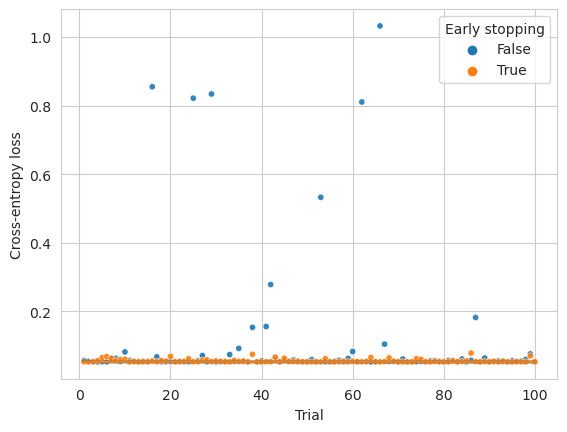

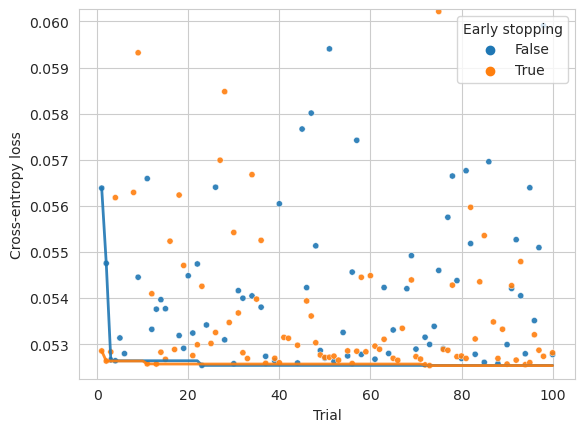

In [15]:
sns.lineplot(
    data=results,
    x='trial', y='best_log_loss', hue='early_stopping',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='log_loss',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='log_loss',
    s=20, alpha=0.9,
)
plt.ylim(0.05225, results['log_loss'].quantile(0.8))
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
plt.legend(title='Early stopping')
plt.show()

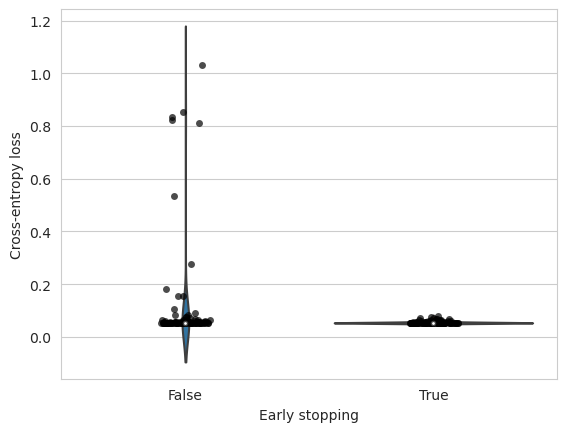

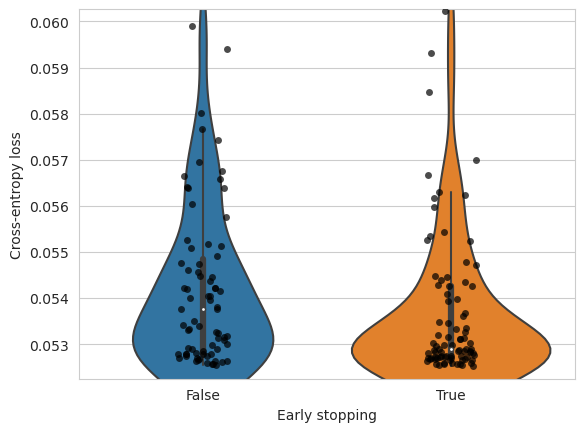

In [16]:
sns.stripplot(data=results, x='early_stopping', y='log_loss', color='black', alpha=0.7)
sns.violinplot(data=results, x='early_stopping', y='log_loss')
plt.xlabel('Early stopping')
plt.ylabel('Cross-entropy loss')
plt.show()

plot_data = results[results['log_loss'] <= results['log_loss'].quantile(0.8)]
sns.stripplot(data=plot_data, x='early_stopping', y='log_loss', color='black', alpha=0.7)
sns.violinplot(data=plot_data, x='early_stopping', y='log_loss')
plt.ylim(0.05225, results['log_loss'].quantile(0.8))
plt.xlabel('Early stopping')
plt.ylabel('Cross-entropy loss')
plt.show()

In [17]:
results.groupby('early_stopping')['log_loss'].mean()

early_stopping
False    0.108057
True     0.055549
Name: log_loss, dtype: float64

### Recall at 5% FPR

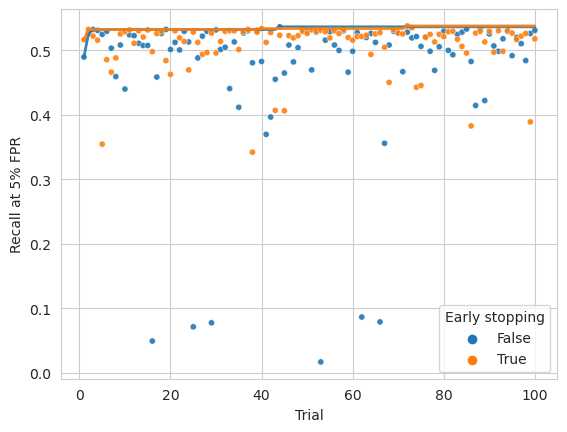

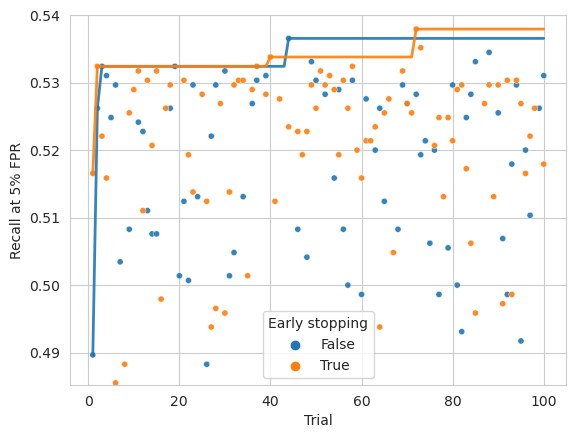

In [18]:
sns.lineplot(
    data=results,
    x='trial', y='best_recall_at_fpr', hue='early_stopping',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='recall_at_fpr',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Recall at 5% FPR')
plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='recall_at_fpr',
    s=20, alpha=0.9,
)
plt.ylim(results['recall_at_fpr'].quantile(0.2), 0.54)
plt.xlabel('Trial')
plt.ylabel('Recall at 5% FPR')
plt.legend(title='Early stopping')
plt.show()

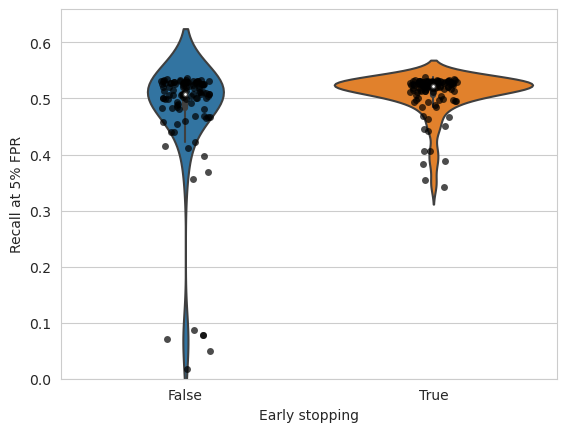

In [19]:
sns.stripplot(data=results, x='early_stopping', y='recall_at_fpr', color='black', alpha=0.7)
sns.violinplot(data=results, x='early_stopping', y='recall_at_fpr')
plt.ylim(bottom=0)
plt.xlabel('Early stopping')
plt.ylabel('Recall at 5% FPR')
plt.show()

In [20]:
results.groupby('early_stopping')['recall_at_fpr'].mean()

early_stopping
False    0.475400
True     0.508166
Name: recall_at_fpr, dtype: float64

## Test set

### Cross-entropy loss

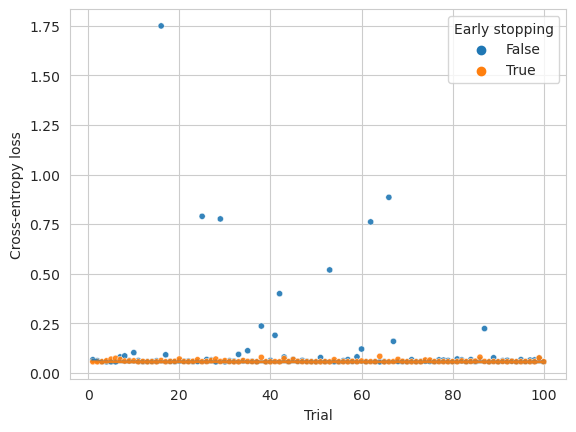

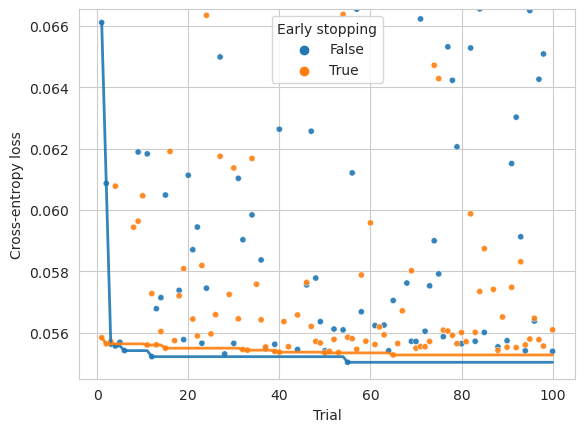

In [21]:
sns.lineplot(
    data=results,
    x='trial', y='test_best_log_loss', hue='early_stopping',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_log_loss',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='test_best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_log_loss',
    s=20, alpha=0.9,
)
plt.ylim(0.0545, results['test_log_loss'].quantile(0.8))
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
plt.legend(title='Early stopping')
plt.show()

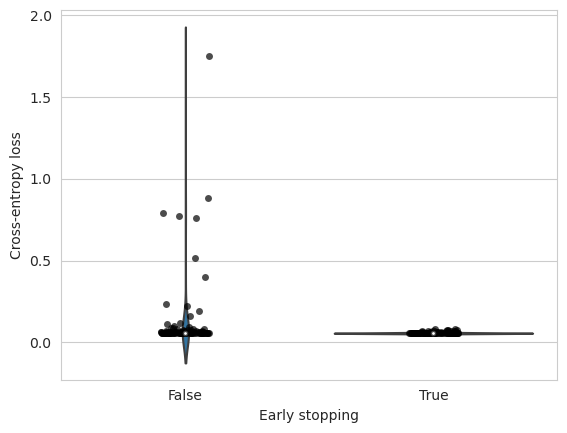

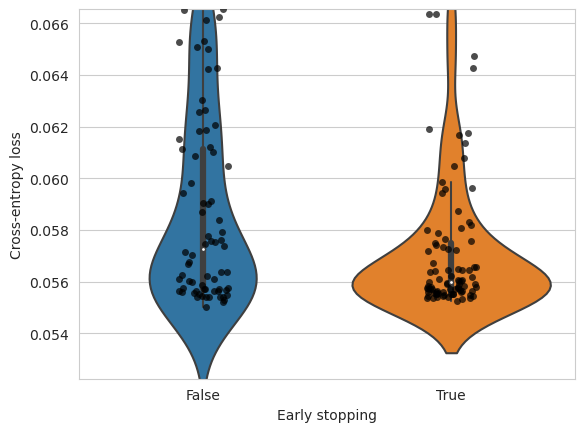

In [22]:
sns.stripplot(data=results, x='early_stopping', y='test_log_loss', color='black', alpha=0.7)
sns.violinplot(data=results, x='early_stopping', y='test_log_loss')
plt.xlabel('Early stopping')
plt.ylabel('Cross-entropy loss')
plt.show()

plot_data = results[results['test_log_loss'] <= results['test_log_loss'].quantile(0.8)]
sns.stripplot(data=plot_data, x='early_stopping', y='test_log_loss', color='black', alpha=0.7)
sns.violinplot(data=plot_data, x='early_stopping', y='test_log_loss')
plt.ylim(0.05225, results['test_log_loss'].quantile(0.8))
plt.xlabel('Early stopping')
plt.ylabel('Cross-entropy loss')
plt.show()

In [23]:
results.groupby('early_stopping')['test_log_loss'].mean()

early_stopping
False    0.123159
True     0.058961
Name: test_log_loss, dtype: float64

### Recall at 5% FPR

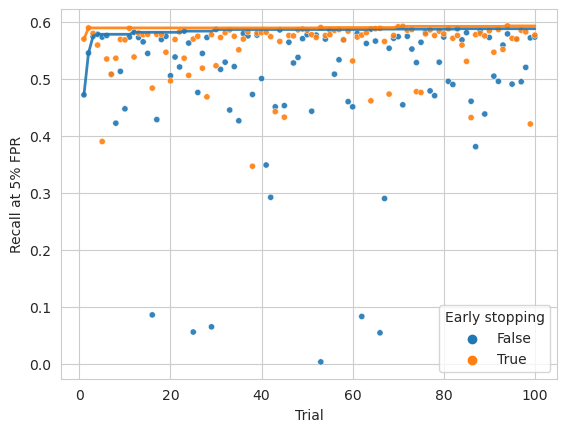

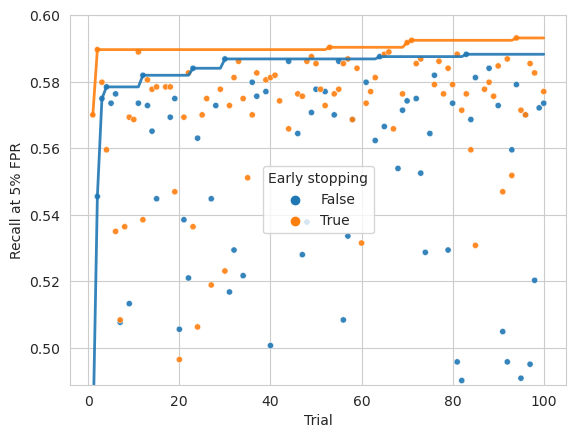

In [24]:
sns.lineplot(
    data=results,
    x='trial', y='test_best_recall_at_fpr', hue='early_stopping',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_recall_at_fpr',
    s=20, alpha=0.9,
)
plt.xlabel('Trial')
plt.ylabel('Recall at 5% FPR')
plt.legend(title='Early stopping')
plt.show()

sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='test_best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_recall_at_fpr',
    s=20, alpha=0.9,
)
plt.ylim(results['test_recall_at_fpr'].quantile(0.2), 0.60)
plt.xlabel('Trial')
plt.ylabel('Recall at 5% FPR')
plt.legend(title='Early stopping')
plt.show()

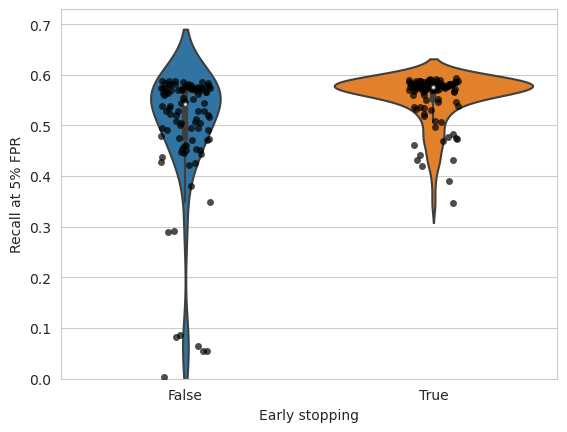

In [25]:
sns.stripplot(data=results, x='early_stopping', y='test_recall_at_fpr', color='black', alpha=0.7)
sns.violinplot(data=results, x='early_stopping', y='test_recall_at_fpr')
plt.ylim(bottom=0)
plt.xlabel('Early stopping')
plt.ylabel('Recall at 5% FPR')
plt.show()

In [26]:
results.groupby('early_stopping')['test_recall_at_fpr'].mean()

early_stopping
False    0.497311
True     0.555336
Name: test_recall_at_fpr, dtype: float64

## Training Time

In [27]:
results['seconds'] = results['duration'].dt.seconds

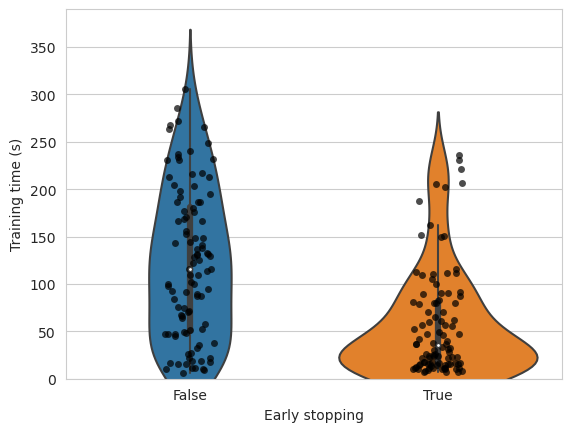

In [28]:
sns.stripplot(data=results, x='early_stopping', y='seconds', color='black', alpha=0.7)
sns.violinplot(data=results, x='early_stopping', y='seconds')
plt.ylim(bottom=0)
plt.xlabel('Early stopping')
plt.ylabel('Training time (s)')
plt.show()

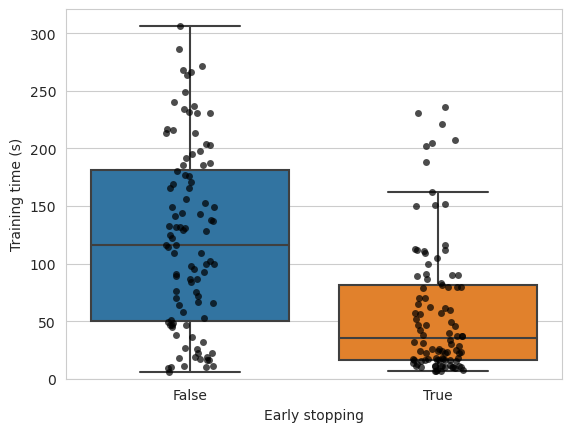

In [29]:
sns.stripplot(data=results, x='early_stopping', y='seconds', color='black', alpha=0.7)
sns.boxplot(data=results, x='early_stopping', y='seconds', showfliers=False)
plt.ylim(bottom=0)
plt.xlabel('Early stopping')
plt.ylabel('Training time (s)')
plt.show()

In [30]:
results.groupby('early_stopping')['seconds'].mean()

early_stopping
False    121.63
True      57.91
Name: seconds, dtype: float64

# Plots for Medium

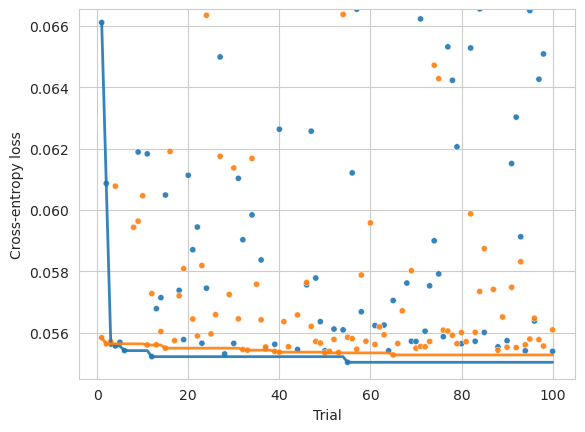

In [31]:
sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='test_best_log_loss',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_log_loss',
    s=20, alpha=0.9, legend=None
)
plt.ylim(0.0545, results['test_log_loss'].quantile(0.8))
plt.xlabel('Trial')
plt.ylabel('Cross-entropy loss')
plt.show()

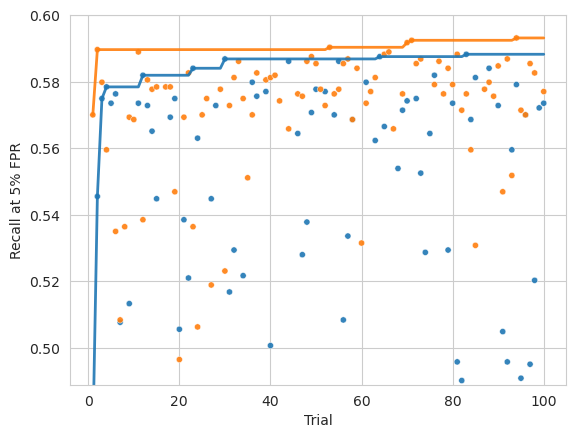

In [32]:
sns.lineplot(
    data=results, hue='early_stopping',
    x='trial', y='test_best_recall_at_fpr',
    linewidth=2, alpha=0.9, legend=None,
)
sns.scatterplot(
    data=results, hue='early_stopping',
    x='trial', y='test_recall_at_fpr',
    s=20, alpha=0.9, legend=None
)
plt.ylim(results['test_recall_at_fpr'].quantile(0.2), 0.60)
plt.xlabel('Trial')
plt.ylabel('Recall at 5% FPR')
plt.show()